# Author : Alexandre Gerzewski Da Silva
## Email  : alexandre19923@gmail.com
## GitHub : AlexandreG1998

In [6]:
import pandas as pd
import random
import numpy as np
import ta as ta
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM, Conv2D, Flatten, MaxPooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from keras.utils.vis_utils import plot_model
import pydot
from keras.models import model_from_json
import graphviz
from tensorflow import keras
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import pandas_datareader
from pandas_datareader import data

import tensorflow.contrib.keras
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import activations

from tensorflow.contrib.keras import callbacks
from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import metrics


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import sklearn.svm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from arch import arch_model
import quandl
from statsmodels.tsa.api import VAR, DynamicVAR
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans

In [7]:
# Function to get OBV indicator, the ta version don't work as expected.
def OBV(close,volume):
    obv = volume
    obv = np.where(close > close.shift(), volume + obv.shift(),obv.shift() - volume)
    return(obv)

In [8]:
# Function to get a SVR model
#Dataset = Data used in nodel, it's a aytoregressive process so it will split in dependent and independent variables
# timestep = Number of previus observations 
#yhed = Target, the variable in x periods ahed
#cut_ = To avoid overfitting in final model it will be used just x percent of total dataset

def get_SVR (dataset = None, timestep = 30, yahed = 1, cut_ = 0.3):
    dataset = pd.DataFrame(dataset)
    dataset.columns = ["X"]
    for i in range(1,timestep):
        nome = "X."+str(i)
        dataset[nome] = dataset["X"].shift()
    dataset = dataset.dropna()
    Y = dataset["X"].shift(-yahed)
    cut = int(cut_ * len(dataset))
    train_x = dataset[:cut].values
    train_y = Y[:cut].values
    model = sklearn.svm.SVR()
    model.fit(train_x,train_y)
    return(model)

In [9]:
#Import Dataset of PETR4.SA 5 minuts period
petr = pd.read_csv("petr4m5.csv", sep=';')
petr = petr.set_index("Data")
petr = petr.dropna()
petr.head()

,Open,High,Low,Close,Tickvol,Volume
Data,,,,,,
2014.10.15 14:30,18.93,19.02,18.93,19.01,1309,872600
2014.10.15 14:35,19.02,19.02,18.96,18.99,1025,832800
2014.10.15 14:40,18.99,19.04,18.93,19.00,1043,1147600
2014.10.15 14:45,18.99,19.13,18.97,19.11,1193,733800
2014.10.15 14:50,19.12,19.16,19.08,19.09,1431,696400


In [10]:
# Prepare Dataset:

petr_ = petr

petr_["Daily Return"] = ((petr_["Close"]/petr_["Close"].shift())-1) * 100
petr_["Y Return"] = ((petr_["Close"]/petr_["Close"].shift(-5))-1) * -100
petr_["Range"] = ((petr_["High"]/petr_["Low"])-1 ) * 100
petr_["Body"] = np.where(petr_["Range"] != 0, 
                         abs((petr_["Close"]-petr_["Open"])/(petr_["High"]-petr_["Low"]) * 100),0)
petr_["OBV"] = OBV(petr_["Close"], petr_["Volume"])
petr_["m20"] = petr_["Close"].rolling(20).mean()
petr_["m200"] = petr_["Close"].rolling(200).mean()
petr_["std20"] = petr_["Close"].rolling(20).std()

petr_["SB20"] = petr_["m20"] + (petr_["std20"] * 2)
petr_["IB20"] = petr_["m20"] - (petr_["std20"] * 2)
petr_["Bp"] = ((petr_["SB20"] - petr_["IB20"])/ petr_["m20"]) * 100
petr_["RSL"] = ((petr_["Close"]/petr_["m20"])-1) * 100
petr_['RSL 200'] = ((petr_["Close"]/petr_["m200"])-1) * 100

petr_["m20 - m200"] =  ((petr_["m20"]/petr_["m200"])-1) * 100
petr_["Return m20"] = ((petr_["m20"]/petr_["m20"].shift())-1) * 100
petr_["Return m200"] = ((petr_["m200"]/petr_["m200"].shift())-1) * 100
petr_["Return STD"] = petr_["Daily Return"].rolling(106).std()

petr_["Squeeze"] = np.where(petr_["Close"] > petr_["SB20"],1,np.where(petr_["Close"] < petr_["IB20"],-1,0))

petr_["Trend"] = np.where((petr_["Daily Return"] > 0) & (petr_["RSL"] > 0) & 
                          (petr_["m20 - m200"] > 0) & (petr_["Return m20"] > 0) & (petr_["Return m200"] > 0),1,
                         np.where((petr_["Daily Return"] < 0) & (petr_["RSL"] < 0) & 
                          (petr_["m20 - m200"] < 0) & (petr_["Return m20"] < 0) & (petr_["Return m200"] < 0),-1,0))


petr_ = petr_.dropna()
petr_ = petr_.drop("m20", axis=1)
petr_ = petr_.drop("m200", axis=1)
petr_ = petr_.drop("SB20", axis=1)
petr_ = petr_.drop("IB20", axis=1)
petr_ = petr_.drop("std20", axis=1)

petr_.head()

,Open,High,Low,Close,Tickvol,Volume,Daily Return,Y Return,Range,Body,OBV,Bp,RSL,RSL 200,m20 - m200,Return m20,Return m200,Return STD,Squeeze,Trend
Data,,,,,,,,,,,,,,,,,,,,
2014.10.20 10:40,18.07,18.10,18.04,18.07,215,302100,0.000000,-2.148106,0.332594,0.000000,91700.0,2.757294,-0.522984,-2.298975,-1.785328,-0.085256,-0.025406,0.513641,0,0
2014.10.20 10:45,18.07,18.09,17.90,17.98,1189,1162300,-0.498063,-0.954520,1.061453,47.368421,-860200.0,2.764003,-0.922992,-2.759037,-1.853149,-0.096339,-0.027304,0.515830,0,-1
2014.10.20 10:50,17.98,18.04,17.98,17.99,349,572300,0.055617,-1.695873,0.333704,16.666667,1734600.0,2.766290,-0.785882,-2.678373,-1.907482,-0.082656,-0.027312,0.515734,0,0
2014.10.20 10:55,18.00,18.01,17.91,17.91,637,690000,-0.444691,-1.129305,0.558347,90.000000,-117700.0,2.832704,-1.120742,-3.079695,-1.981157,-0.107542,-0.032459,0.514825,0,-1
2014.10.20 11:00,17.93,17.93,17.81,17.85,925,1159700,-0.335008,-0.393701,0.673779,66.666667,-469700.0,2.789191,-1.310333,-3.371967,-2.089006,-0.143543,-0.033551,0.515466,0,-1


In [11]:
# Get SVR :
svm_STD_returns1 = get_SVR(petr_.iloc[:,17:18].values)
svm_STD_returns2 = get_SVR(petr_.iloc[:,17:18].values, yahed=2)
svm_STD_returns3 = get_SVR(petr_.iloc[:,17:18].values, yahed=3)
svm_STD_returns4 = get_SVR(petr_.iloc[:,17:18].values, yahed=4)
svm_STD_returns5 = get_SVR(petr_.iloc[:,17:18].values, yahed=5)

In [12]:
# Get sequence data and forecast next STD of returns:

for i in range(1,30):
    nome = None
    nome = "RetornoL."+str(i)
    petr_[nome] = petr_["Daily Return"].shift(i)
for i in range(1,30):
    nome = None
    nome = "RangeL."+str(i)
    petr_[nome] = petr_["Range"].shift(i)
for i in range(1,30):
    nome = None
    nome = "BodyL."+str(i)
    petr_[nome] = petr_["Body"].shift(i)
for i in range(1,30):
    nome = None
    nome = "OBVL."+str(i)
    petr_[nome] = petr_["OBV"].shift(i)
    
    nome = "BpL."+str(i)
for i in range(1,30):
    nome = None
    petr_[nome] = petr_["Bp"].shift(i)
    
for i in range(1,30):
    nome = None
    nome = "RSL20L."+str(i)
    petr_[nome] = petr_["RSL"].shift(i)
for i in range(1,30):
    nome = None
    nome = "RSL200L."+str(i)
    petr_[nome] = petr_["RSL 200"].shift(i)
    
for i in range(1,30):
    nome = None
    nome = "TrendL."+str(i)
    petr_[nome] = petr_["Trend"].shift(i)
    
for i in range(1,30):
    nome = None
    nome = "Return STDL."+str(i)
    petr_[nome] = petr_["Return STD"].shift(i)

    
petr_ = petr_.dropna()

print(petr_.columns)


preverSTD =petr_.iloc[:,17:18]


for i in range(1,30):
    nome = None
    nome = "Return STDL."+str(i)
    preverSTD[nome] = petr_[nome]


petr_["STD y1"] = svm_STD_returns1.predict(preverSTD.values)
petr_["STD y2"] = svm_STD_returns2.predict(preverSTD.values)
petr_["STD y3"] = svm_STD_returns3.predict(preverSTD.values)
petr_["STD y4"] = svm_STD_returns4.predict(preverSTD.values)
petr_["STD y5"] = svm_STD_returns5.predict(preverSTD.values)


Index([          'Open',           'High',            'Low',          'Close',
              'Tickvol',         'Volume',   'Daily Return',       'Y Return',
                'Range',           'Body',
       ...
       'Return STDL.20', 'Return STDL.21', 'Return STDL.22', 'Return STDL.23',
       'Return STDL.24', 'Return STDL.25', 'Return STDL.26', 'Return STDL.27',
       'Return STDL.28', 'Return STDL.29'],
      dtype='object', length=253)


In [13]:
petr_.head()

,Open,High,Low,Close,Tickvol,Volume,Daily Return,Y Return,Range,Body,...,Return STDL.25,Return STDL.26,Return STDL.27,Return STDL.28,Return STDL.29,STD y1,STD y2,STD y3,STD y4,STD y5
Data,,,,,,,,,,,,,,,,,,,,,
2014.10.20 13:05,17.72,17.79,17.68,17.78,979,498200,0.282008,0.447928,0.622172,54.545455,...,0.515466,0.514825,0.515734,0.515830,0.513641,0.431002,0.424643,0.421312,0.420104,0.418266
2014.10.20 13:10,17.78,17.84,17.75,17.82,820,259100,0.224972,0.056085,0.507042,44.444444,...,0.521632,0.515466,0.514825,0.515734,0.515830,0.430470,0.424294,0.421094,0.419953,0.418189
2014.10.20 13:15,17.82,17.87,17.75,17.82,969,556700,0.000000,-0.000000,0.676056,0.000000,...,0.525689,0.521632,0.515466,0.514825,0.515734,0.429546,0.423545,0.420471,0.419391,0.417692
2014.10.20 13:20,17.83,17.87,17.80,17.81,787,193800,-0.056117,0.279955,0.393258,28.571429,...,0.529208,0.525689,0.521632,0.515466,0.514825,0.428173,0.422336,0.419380,0.418353,0.416708
2014.10.20 13:25,17.81,17.88,17.81,17.82,795,279200,0.056148,0.056085,0.393038,14.285714,...,0.525127,0.529208,0.525689,0.521632,0.515466,0.426944,0.421277,0.418443,0.417471,0.415884


In [14]:
# Delete the no squeeze rows
backup = petr_
df = petr_.drop(petr_[petr_["Squeeze"] == 0].index,  inplace=True)
petr_.iloc[:,6:].head()
df = petr_.iloc[:,6:]


In [15]:
df.head()

,Daily Return,Y Return,Range,Body,OBV,Bp,RSL,RSL 200,m20 - m200,Return m20,...,Return STDL.25,Return STDL.26,Return STDL.27,Return STDL.28,Return STDL.29,STD y1,STD y2,STD y3,STD y4,STD y5
Data,,,,,,,,,,,,,,,,,,,,,
2014.10.20 14:55,-0.560224,-0.112803,0.619718,90.909091,-14300.0,0.767215,-0.524000,-2.702673,-2.190149,-0.019611,...,0.381961,0.381706,0.383410,0.390339,0.392231,0.410724,0.407648,0.406635,0.406512,0.405924
2014.10.20 15:00,0.056338,0.056275,0.395034,14.285714,1347300.0,0.860375,-0.454010,-2.637984,-2.193935,-0.014011,...,0.381723,0.381961,0.381706,0.383410,0.390339,0.410562,0.407495,0.406490,0.406368,0.405782
2014.10.20 15:15,-0.281215,-0.282805,0.564653,40.000000,-117000.0,1.064456,-0.566429,-2.769133,-2.215251,-0.028033,...,0.383373,0.382866,0.381562,0.381723,0.381961,0.411039,0.407994,0.407003,0.406894,0.406325
2014.10.20 15:35,-0.620068,0.564016,0.681044,91.666667,-851700.0,1.503417,-0.977308,-3.257315,-2.302509,-0.075768,...,0.382785,0.381944,0.382472,0.383284,0.383373,0.412634,0.409619,0.408648,0.408565,0.408032
2014.10.20 16:20,-1.014085,-1.209677,1.537585,66.666667,-1287400.0,1.558232,-0.924777,-3.458621,-2.557495,-0.070436,...,0.383303,0.384928,0.384118,0.384575,0.384757,0.421711,0.418851,0.417985,0.418041,0.417708


In [16]:
# Prepare dataset for input in ANN

Y = df.iloc[:,1:2]
df = df.drop("Y Return", axis=1)

Yc = np.where(Y["Y Return"] > 0 ,1,0)

# Use MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))



cut = int(df.shape[0] * 0.7)

x_train = df[:cut].values
y_train = Yc[:cut]

x_test = df[cut:].values
y_test = df[cut:]

# Slip in train and test dataset
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)

#Use full dataset for final test
df_scaled = sc.transform(df.values)

In [17]:
model = Sequential()
model.add(Dense(units=251, input_dim = x_train_scaled.shape[1], activation="relu"))
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = "sigmoid"))

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics=["acc"])

history = model.fit(x_train_scaled, y_train, batch_size=1000, epochs=100)

Epoch 1/100
7942/7942 [==============================] - 4s 543us/step - loss: 0.6982 - acc: 0.5133
Epoch 2/100
7942/7942 [==============================] - 2s 256us/step - loss: 0.6926 - acc: 0.5208
Epoch 3/100
7942/7942 [==============================] - 3s 338us/step - loss: 0.6909 - acc: 0.5373
Epoch 4/100
7942/7942 [==============================] - 2s 251us/step - loss: 0.6900 - acc: 0.5274
Epoch 5/100
7942/7942 [==============================] - 2s 215us/step - loss: 0.6916 - acc: 0.5209
Epoch 6/100
7942/7942 [==============================] - 2s 246us/step - loss: 0.6898 - acc: 0.5300 0s - loss: 0.6883 - acc: 0.
Epoch 7/100
7942/7942 [==============================] - 2s 224us/step - loss: 0.6887 - acc: 0.5412
Epoch 8/100
7942/7942 [==============================] - 2s 249us/step - loss: 0.6886 - acc: 0.5426
Epoch 9/100
7942/7942 [==============================] - 2s 207us/step - loss: 0.6876 - acc: 0.5427
Epoch 10/100
7942/7942 [==============================] - 3s 360us/step 

7942/7942 [==============================] - 1s 160us/step - loss: 0.5371 - acc: 0.7260
Epoch 81/100
7942/7942 [==============================] - 1s 143us/step - loss: 0.5291 - acc: 0.7254
Epoch 82/100
7942/7942 [==============================] - 1s 133us/step - loss: 0.5160 - acc: 0.7352
Epoch 83/100
7942/7942 [==============================] - 1s 146us/step - loss: 0.5207 - acc: 0.7297
Epoch 84/100
7942/7942 [==============================] - 1s 138us/step - loss: 0.5155 - acc: 0.7392
Epoch 85/100
7942/7942 [==============================] - 1s 136us/step - loss: 0.4950 - acc: 0.7591
Epoch 86/100
7942/7942 [==============================] - 1s 153us/step - loss: 0.4916 - acc: 0.7566
Epoch 87/100
7942/7942 [==============================] - 1s 134us/step - loss: 0.5021 - acc: 0.7509
Epoch 88/100
7942/7942 [==============================] - 1s 138us/step - loss: 0.4882 - acc: 0.7586
Epoch 89/100
7942/7942 [==============================] - 1s 134us/step - loss: 0.4795 - acc: 0.7663
Epo

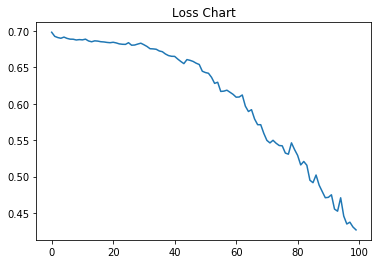

In [18]:
plt.plot(history.history["loss"])
plt.title("Loss Chart")
plt.show()

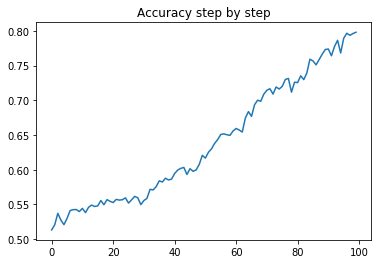

In [52]:
plt.plot(history.history["acc"])
plt.title("Accuracy step by step")
plt.show()

In [53]:
Y["Previsto"] = model.predict(df_scaled)
#Get the class by quartile 
Y["Classe"] = np.where(Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=10 ),1,
                       np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=20))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=10)),2,
                    
                        np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=30))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=20)),3,
                        
                        np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=40))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=30)),4,
                                
                        np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=50))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=40)),5,
                       
                        np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=60))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=50)),6,
                                
                        np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=70))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=60)),7,
                                
                        np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=80))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=70)),8,
                                
                        np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=90))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=70)),9,10)))))))))


Y["Pos/Neg"] = np.where(Y["Y Return"] > 0,1,0 )
#Use to backtest the last 30% of dataset
Y[:cut].groupby(["Classe","Pos/Neg"])["Y Return"].sum()


Classe  Pos/Neg
1       0         -589.418752
        1            1.582359
2       0         -421.843158
        1           18.166036
3       0         -440.473807
        1           43.089194
4       0         -301.370278
        1           85.920647
5       0         -293.949061
        1          154.016538
6       0         -176.946377
        1          246.426409
7       0         -116.503504
        1          303.966004
8       0          -44.028611
        1          407.127354
9       0          -11.975268
        1          448.364555
10      0           -9.506619
        1          558.904326
Name: Y Return, dtype: float64

In [54]:
Y["Squeeze"] = df["Squeeze"].values
Y["Sinal"] = np.where(Y["Classe"] == 10, 1,np.where(Y["Classe"] == 1,-1,0))

Y["Pontos"] = Y["Y Return"] * Y["Sinal"]

Y["Machine Learning Squeeze"] = Y["Pontos"].cumsum()

Y_ = Y[cut:]
Y_["Machine Learning Squeeze"] = Y_["Pontos"].cumsum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [55]:
Y_["Gain"] = np.where(Y_["Pontos"] > 0,1,0)
Y_['Points of Classical Squeeze'] = Y_['Y Return'] * Y_['Squeeze']
Y_['Cumulative Squeeze'] = Y_['Points of Classical Squeeze'].cumsum()
Y_['Squeeze gain'] = np.where(Y_['Points of Classical Squeeze']>0,1,0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [56]:
print("Hit rate Classical Squeeze  :", 100 *( (sum(Y_['Squeeze gain'])) / (Y_.shape[0])) )
print("Hit rate Squeeze with Machine Learning  :", 100 *( (sum(Y_["Gain"])) / (sum(abs(Y_['Sinal'])))) )

Hit rate Classical Squeeze  : 45.12338425381904
Hit rate Squeeze with Machine Learning  : 51.388888888888886


In [57]:
Y_ = Y_.reset_index()

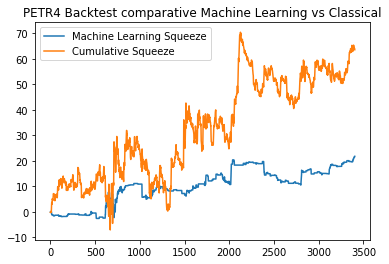

In [58]:
plt.plot(Y_["Machine Learning Squeeze"])
plt.plot(Y_['Cumulative Squeeze'])
plt.legend()
plt.title("PETR4 Backtest comparative Machine Learning vs Classical")
plt.show()